In [1]:
!pip install fastai --upgrade --quiet

     |████████████████████████████████| 194kB 5.8MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 


In [2]:
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saurava","key":"44021ce0500c4057d32849f9ae9484e4"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [5]:


! chmod 600 ~/.kaggle/kaggle.json

In [6]:
import os
os.mkdir('emotions_recogination')

In [7]:
!kaggle datasets download -d deadskull7/fer2013

 84% 81.0M/96.6M [00:04<00:01, 8.80MB/s]
100% 96.6M/96.6M [00:04<00:00, 20.8MB/s]


In [8]:
from fastai.data.core import DataLoaders

In [9]:
import os
import zipfile

local_zip = '/content/fer2013.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('emotions_recogination')
zip_ref.close()


In [10]:
df=pd.read_csv('/content/emotions_recogination/fer2013.csv')
df['Usage'].unique()
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 1...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 154 153 164 173 178 185 185 189 187 186 193 194 185 183 186 180 173 166 161 147 133 172 151 114 161 161 146 131 104 95 132 163 123 119 129 140 120 151 149 149 153 137 115 129 166 170 181 164 143 157 156 169 179 185 183 186 186 184 190 191 184 186 190 183 175 168 160 147 136 135 167 136 108 153 167 149 137 111 90 134 162 121 122 141 137 151 151 156 143 116 124 159 164 174 169 135 144 155 153 164 170 176 178 177 178 187 185 181 182 183 181 178 170 164 158 148 144 130 136 173 130 97 137 167 157 138 113 90 138 168 109 123 146 151 152 155 127 113 159 ...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38 39 74 138 161 164 179 190 201 210 216 220 224 222 218 216 213 217 220 220 218 217 212 174 160 162 160 139 135 137 131 94 56 36 44 27 16 229 175 148 173 154 151 171 172 183 101 23 25 67 127 164 170 171 182 199 212 219 220 224 226 226 226 226 226 227 227 228 225 221 217 202 174 158 155 145 126 126 129 99 70 37 27 35 27 214 156 157 168 153 172 168 175 100 16 8 47 117 169 175 175 183 194 204 214 218 223 225 227 228 226 229 231 232 232 229 227 225 224 217 198 174 154 134 110 97 115 96 69 52 28 22 28 202 153 166 156 164 166 170 116 26 2 21 90 165 18...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 19 43 52 13 26 40 59 65 12 20 63 99 98 98 111 75 62 41 73 118 140 192 186 187 188 190 190 187 182 176 173 172 173 25 34 29 35 29 26 20 23 19 31 22 21 20 31 26 17 34 75 37 18 38 80 85 25 38 26 34 97 94 76 86 95 70 39 98 129 185 188 188 189 190 190 188 182 176 173 172 173 26 29 25 35 25 30 20 21 16 28 34 26 15 17 19 22 29 62 64 47 45 76 76 78 65 82 12 14 56 56 72 74 66 65 86 129 172 190 187 189 190 190 187 182 177 172 172 174 26 33 32 31 25 33 26 21 16 16 37 27 14 15 12 17 31 38 40 58 73 59 35 82 68 72 43 22 33 52 51 66 71 57 71 121 160 191 188 18...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84 115 127 137 142 151 156 155 149 153 152 157 160 162 159 145 121 83 58 48 38 21 17 7 5 25 27 24 25 1 0 0 0 0 0 0 0 0 0 0 6 18 26 37 50 62 83 115 134 138 144 147 150 162 163 164 161 165 169 171 176 175 177 169 147 110 79 64 42 23 13 9 2 16 26 23 26 0 0 0 0 0 0 0 0 0 1 6 18 29 49 73 93 116 129 138 143 148 153 158 158 162 168 170 169 170 176 181 185 186 183 180 167 143 109 81 54 29 11 8 3 10 27 26 26 0 0 0 0 0 0 0 0 0 8 32 55 74 94 108 121 127 132 138 145 154 159 160 162 166 170 174 173 177 181 183 183 186 188 188 180 164 138 113 69 36 14 4 3 11 2...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 50 53 60 67 69 72 73 82 86 87 94 94 89 84 78 78 80 73 68 63 59 56 56 56 43 33 25 60 80 78 80 79 81 46 23 18 22 26 31 37 38 35 37 38 37 39 44 49 52 57 61 64 66 71 74 83 87 92 96 96 95 90 83 84 81 79 72 63 60 57 55 57 49 35 27 38 78 77 79 80 80 37 19 19 22 27 31 41 40 37 37 36 38 39 43 49 52 52 56 62 64 74 83 87 90 99 97 100 99 90 91 86 79 80 72 68 62 57 54 56 50 40 31 26 66 78 78 80 80 30 17 20 22 25 33 40 41 37 37 36 37 39 43 47 51 57 64 68 70 78 85 87 89 106 101 87 92 88 88 85 81 79 73 70 62 56 55 54 53 46 38 28 46 76 78 80 81 23 18 18 22 27 34...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 201 204 206 202 195 185 182 183 184 188 191 194 192 187 182 182 184 187 189 190 187 184 180 172 167 164 162 159 159 161 169 171 168 145 78 41 57 181 178 178 180 185 191 196 196 199 202 204 204 207 209 207 199 187 184 182 184 

In [11]:
path=Path('/content/emotions_recogination')

In [12]:
class EmotionImage(fastuple):
    def show(self, ctx=None, **kwargs):
        img, emotion = self
        if not isinstance(img, Tensor):
          image=tensor(img).float()/255.0
          image=image.unsqueeze(0)
          image=image.expand(3,48,48)
          
          img_tensor = image
        else:
          img_tensor = img
        return show_image(img_tensor,title=emotion, ctx=ctx, **kwargs)

In [14]:
width,height=48,48
image_size=(48,48)
class EmotionDataset2(Transform):
  def __init__(self,df):
    super(EmotionDataset2,self).__init__()
    self.df=df
  

  def __len__(self):
    return len(self.df)

  def encodes(self,idx):
    # print(idx)
    idx=idx.name
  
    torch.Tensor.ndim = property(lambda x: len(x.shape))
    # print(idx.name)
    # emotion=idx['emotion']
    emotion=df['emotion'].iloc[idx]

    torch.Tensor.ndim = property(lambda x: len(x.shape))
    one_hot_targets = torch.tensor(np.eye(7)[emotion]).type(torch.FloatTensor)
  
    arr=df['pixels'].iloc[idx]
    # print(arr)
    # arr=list(map(int,pixels.split(' ')))

    array=np.array(arr).reshape(width, height)
    img= Image.fromarray((array).astype('uint8'))
    # image=to_image(img)
    image=PILImage(img)
    
    return EmotionImage(image ,one_hot_targets)

  

In [15]:
@typedispatch
def show_batch(x:EmotionImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): EmotionImage((x[0][i], str( torch.max(x[1][i]).item() ) ) ).show(ctx=ctx)

In [16]:
for i in range(len(df)):
  pixels=df['pixels'].iloc[i]
  arr=list(map(int,pixels.split(' ')))
  df['pixels'].iloc[i]=np.array(arr)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [17]:
df.head()

,emotion,pixels,Usage
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 48, 89, 115, 121, 119, 115, 110, 98, 91, 84, 84, 90, 99, 110, 126, 143, 153, 158, 171, 169, 172, 169, 165, 129, 110, 113, 107, 95, 79, 66, 62, 56, 57, 61, 52, 43, 41, 65, 61, 58, 57, 56, 69, 75, 70, 65, 56, 54, 105, 146, 154, 151, 151, 155, 155, 150, 147, 147, 148, 152, 158, 164, 172, 177, 182, 186, 189, 188, 190, 188, 180, 167, 116, 95, 103, 97, 77, 72, 62, 55, 58, 54, 56, 52, 44, 50, 43, 54, 64, ...]",Training
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, 174, 182, 154, 153, 164, 173, 178, 185, 185, 189, 187, 186, 193, 194, 185, 183, 186, 180, 173, 166, 161, 147, 133, 172, 151, 114, 161, 161, 146, 131, 104, 95, 132, 163, 123, 119, 129, 140, 120, 151, 149, 149, 153, 137, 115, 129, 166, 170, 181, 164, 143, 157, 156, 169, 179, 185, 183, 186, 186, 184, 190, 191, 184, 186, 190, 183, 175, 168, 160, 147, 136, 135, 167, 136, 108, 153, 167, 149, 137, 111, 90, 134, 162, 121, 122, 141, 137, 151, 151, 156, 143, ...]",Training
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, 200, 106, 38, 39, 74, 138, 161, 164, 179, 190, 201, 210, 216, 220, 224, 222, 218, 216, 213, 217, 220, 220, 218, 217, 212, 174, 160, 162, 160, 139, 135, 137, 131, 94, 56, 36, 44, 27, 16, 229, 175, 148, 173, 154, 151, 171, 172, 183, 101, 23, 25, 67, 127, 164, 170, 171, 182, 199, 212, 219, 220, 224, 226, 226, 226, 226, 226, 227, 227, 228, 225, 221, 217, 202, 174, 158, 155, 145, 126, 126, 129, 99, 70, 37, 27, 35, 27, 214, 156, 157, 168, ...]",Training
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 22, 32, 34, 21, 19, 43, 52, 13, 26, 40, 59, 65, 12, 20, 63, 99, 98, 98, 111, 75, 62, 41, 73, 118, 140, 192, 186, 187, 188, 190, 190, 187, 182, 176, 173, 172, 173, 25, 34, 29, 35, 29, 26, 20, 23, 19, 31, 22, 21, 20, 31, 26, 17, 34, 75, 37, 18, 38, 80, 85, 25, 38, 26, 34, 97, 94, 76, 86, 95, 70, 39, 98, 129, 185, 188, 188, 189, 190, 190, 188, 182, 176, 173, 172, 173, 26, 29, 25, 35, ...]",Training
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23, 28, 48, 50, 58, 84, 115, 127, 137, 142, 151, 156, 155, 149, 153, 152, 157, 160, 162, 159, 145, 121, 83, 58, 48, 38, 21, 17, 7, 5, 25, 27, 24, 25, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 18, 26, 37, 50, 62, 83, 115, 134, 138, 144, 147, 150, 162, 163, 164, 161, 165, 169, 171, 176, 175, 177, 169, 147, 110, 79, 64, 42, 23, 13, 9, 2, 16, 26, 23, 26, 0, 0, 0, 0, ...]",Training


In [18]:
splits = RandomSplitter()(df)
# splits
tfm = EmotionDataset2(df)
splits

((#28710) [15472,24714,2056,14608,26807,3726,15565,6106,17233,10794...],
 (#7177) [28791,31222,24529,1612,13985,23263,31459,12121,9080,12391...])

In [19]:
tls = TfmdLists(df, tfm,splits=splits)

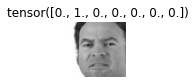

In [20]:
show_at(tls.valid, 0)

In [21]:
dls = tls.dataloaders(after_item=[ToTensor], 
                      batch_tfms=[Normalize.from_stats(*imagenet_stats)])
dls.cuda()

In [22]:
dls = tls.dataloaders(after_item=[ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

dls.cuda()

In [ ]:
b = dls.one_batch()
b

In [24]:
dls._types,type(b)

({__main__.EmotionImage: [fastai.torch_core.TensorImage, torch.Tensor]},
 __main__.EmotionImage)

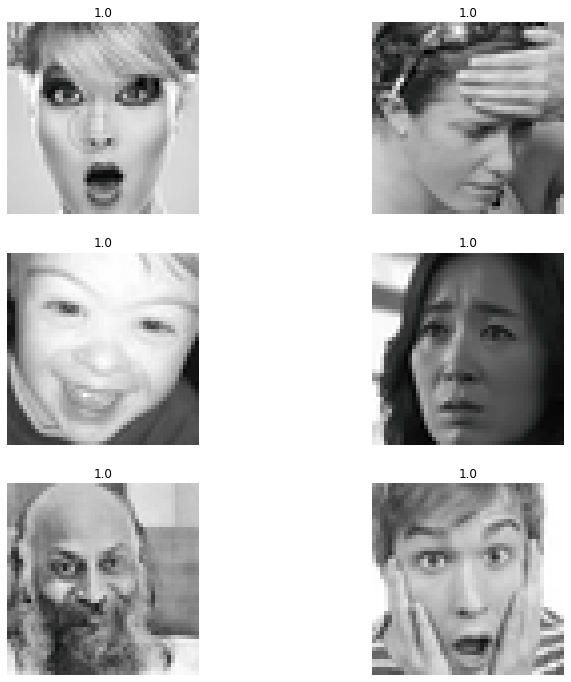

In [25]:
dls.show_batch()

In [26]:
dls.c=7

In [27]:
learn=cnn_learner(dls,arch=models.resnet18, loss_func=nn.BCEWithLogitsLoss(), opt_func=Adam,metrics=accuracy_multi, cbs=CudaCallback)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [28]:

x,y = to_cpu(dls.train.one_batch())
print(x.shape)
activs = learn.model(x)
activs

(64, 3, 48, 48)


tensor([[ 5.8827e-01,  1.3938e+00,  3.6762e-01,  1.0187e+00, -1.2684e+00,
         -1.8702e+00, -1.0244e+00],
        [ 2.6026e+00,  5.9460e-01, -4.5735e+00, -2.2398e+00, -2.5668e-01,
         -9.1614e-01,  9.0380e-01],
        [-9.8989e-01, -1.6091e+00, -1.0940e+00,  4.1969e+00,  1.2294e+00,
          1.5809e+00,  1.0913e+00],
        [-3.2138e-01, -1.7353e+00,  4.3692e-01, -3.0477e+00,  2.3505e+00,
          3.0755e-01, -7.3365e-01],
        [-1.6699e+00, -3.7591e+00, -1.1522e+00,  2.9220e-01, -3.8049e-01,
          2.1431e+00,  1.9065e+00],
        [-8.8583e-01,  2.3809e-02,  1.0638e+00, -1.9416e+00,  3.0871e+00,
          1.7238e+00,  1.8625e+00],
        [ 3.8793e-01, -2.4201e-01,  4.3704e-01, -1.1156e+00,  6.3934e-02,
          1.9700e+00, -1.4421e+00],
        [-1.6378e+00, -3.5857e+00,  8.5440e-01, -1.7116e+00, -5.4089e+00,
          4.3127e+00,  1.0203e+00],
        [ 2.6454e-01,  5.9569e-01,  7.7691e-01, -1.2315e+00, -9.2319e-01,
          6.6635e-01,  1.2043e-01],
        [-

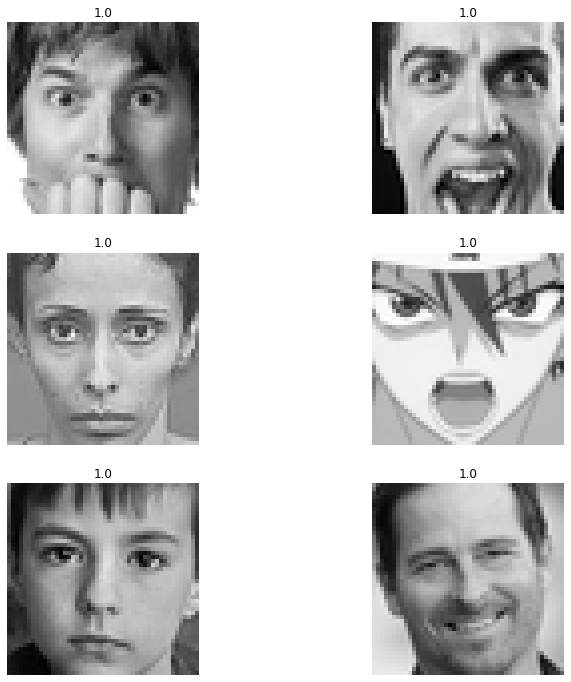

In [29]:
dls.show_batch()

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.033113110810518265)

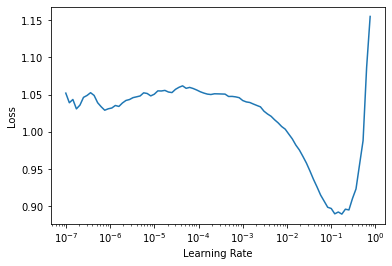

In [30]:
learn.lr_find()

In [31]:
learn.freeze()

In [32]:
learn.fit_one_cycle(15,1e-02)                              

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.408147,0.360819,0.862159,00:32
1,0.324506,0.311953,0.878580,00:32
2,0.304233,0.292537,0.881805,00:32
3,0.294612,0.286687,0.884233,00:32
4,0.286494,0.280877,0.884811,00:32
5,0.280354,0.280956,0.885846,00:32
6,0.271731,0.269768,0.889906,00:33
7,0.267250,0.273797,0.888772,00:33
8,0.266376,0.269553,0.888652,00:33
9,0.257021,0.264344,0.891220,00:33


In [33]:
learn.unfreeze()


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=3.311311274956097e-06)

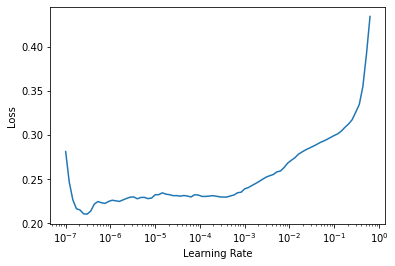

In [35]:
learn.lr_find()

In [36]:
learn.fit_one_cycle(5,1e-06)                              

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.236362,0.262170,0.892594,00:34
1,0.232719,0.260156,0.893250,00:34
2,0.227628,0.259960,0.892991,00:34
3,0.230647,0.260898,0.893648,00:34
4,0.228657,0.260356,0.893190,00:34


In [37]:
# intrep=Interpretation.from_learner(learn)

In [38]:
# intrep.plot_top_losses(9, figsize=(15,10))

In [39]:
# learn.show_results()

In [40]:
learn.freeze()

In [41]:
learn.export()                                                                             


In [58]:
i=PILImage.create("/content/download (1).png",mode='L')

In [69]:
m=PILImage(i)
print(type(m))

<class 'fastai.vision.core.PILImage'>


In [70]:
# k=EmotionImage(i)


In [61]:
pred=learn.predict(k)

In [62]:
p=torch.argmax(pred[0])

In [63]:
id=p.item()                                                                      

In [56]:
objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [57]:
objects[2]

'fear'